In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from propy import PyPro
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import time
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from bayes_opt import BayesianOptimization
import numpy as np
from bayes_opt import BayesianOptimization
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif


In [2]:
# Connect to the database and read the data
con = sqlite3.connect("unified_CD2.db")
df = pd.read_sql_query("SELECT * FROM prod_desc", con)
df["AB"] = df["AB"].apply(lambda x: int.from_bytes(x, "little"))
columns_to_drop = ["index", "id", "name", "description", "OX", "source", "valid"]
df = df.drop(columns=columns_to_drop)



In [3]:
# split of data to target
X = df.drop(columns=['AB',"seq"])
y = df['AB']


#Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)












In [4]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Initial Model Training and Evaluation(4 min)
initial_model = SVC()

# Fit the initial model
initial_model.fit(X_train, y_train)

# Evaluate initial model accuracy on the test set
initial_model_accuracy = accuracy_score(y_test, initial_model.predict(X_test))
print("Initial Model Accuracy:", initial_model_accuracy)

# Generate classification report
y_pred_initial = initial_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred_initial))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_initial))

# Perform cross-validation
cv_score_initial = cross_val_score(initial_model, X_train, y_train, cv=5)


# Print cross-validation scores
print("Cross-Validation Scores:", cv_score_initial)
print("Mean Cross-Validation Accuracy:", np.mean(cv_score_initial))


Initial Model Accuracy: 0.7379929714955096
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      1174
           1       0.77      0.73      0.75      1387

    accuracy                           0.74      2561
   macro avg       0.74      0.74      0.74      2561
weighted avg       0.74      0.74      0.74      2561

Confusion Matrix:
[[ 872  302]
 [ 369 1018]]
Cross-Validation Scores: [0.73486328 0.72167969 0.73535156 0.7578125  0.73486328]
Mean Cross-Validation Accuracy: 0.7369140625


Not too bad for initial model, but computation time quite high, so feature selection for most important features and see, if accuracy decreases much

In [4]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=43)

# Remove constant features
constant_filter = VarianceThreshold(threshold=0)
X_train_nonconstant = constant_filter.fit_transform(X_train, y_train)
X_test_nonconstant = constant_filter.transform(X_test)

# Feature selection on non-constant features
selector = SelectKBest(f_classif, k=75)
X_train_selected = selector.fit_transform(X_train_nonconstant, y_train)
X_test_selected = selector.transform(X_test_nonconstant)

# Model Training and Evaluation after Feature Selection (2min)
selected_model = SVC()

# Perform cross-validation
cv_scores = cross_val_score(selected_model, X_train_selected, y_train, cv=5)

# Train the model
selected_model.fit(X_train_selected, y_train)

# Evaluate model accuracy
selected_model_accuracy = accuracy_score(y_test, selected_model.predict(X_test_selected))
print("Model Accuracy after Feature Selection (without cross-validation):", selected_model_accuracy)

# Generate classification report
y_pred_selected = selected_model.predict(X_test_selected)
print("Classification Report:")
print(classification_report(y_test, y_pred_selected))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_selected))

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))


Model Accuracy after Feature Selection (without cross-validation): 0.7571261226083561
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      1156
           1       0.78      0.77      0.78      1405

    accuracy                           0.76      2561
   macro avg       0.75      0.76      0.76      2561
weighted avg       0.76      0.76      0.76      2561

Confusion Matrix:
[[ 851  305]
 [ 317 1088]]
Cross-Validation Scores: [0.74560547 0.73925781 0.73876953 0.74560547 0.73291016]
Mean Cross-Validation Accuracy: 0.7404296875


Accuracy actually increased and computation time also, but further probing with pca


In [14]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=4)

# Remove constant features
constant_filter = VarianceThreshold(threshold=0)
X_train_nonconstant = constant_filter.fit_transform(X_train, y_train)
X_test_nonconstant = constant_filter.transform(X_test)

# Feature selection on non-constant features
selector = SelectKBest(f_classif, k=75)
X_train_selected = selector.fit_transform(X_train_nonconstant, y_train)
X_test_selected = selector.transform(X_test_nonconstant)

# Perform PCA with explained variance threshold of 95%
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)


In [15]:



#Model Training and Evaluation after PCA
pca_model = SVC()

# Perform k-fold cross-validation
cv_scores = cross_val_score(pca_model, X_train_pca, y_train, cv=5)


# Fit the model on the entire training set
pca_model.fit(X_train_pca, y_train)

# Evaluate model accuracy on the test set
pca_model_accuracy = accuracy_score(y_test, pca_model.predict(X_test_pca))
print("Model Accuracy after PCA:", pca_model_accuracy)

# Step 1: Performance Metrics
# Generate classification report
y_pred = pca_model.predict(X_test_pca)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Print out the number of retained principal components
print("Number of retained principal components:", pca.n_components_)


Model Accuracy after PCA: 0.7192502928543538
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.69      1166
           1       0.74      0.76      0.75      1395

    accuracy                           0.72      2561
   macro avg       0.72      0.72      0.72      2561
weighted avg       0.72      0.72      0.72      2561

Confusion Matrix:
[[ 787  379]
 [ 340 1055]]
Cross-Validation Scores: [0.72753906 0.71533203 0.71923828 0.72265625 0.72167969]
Mean CV Accuracy: 0.7212890625
Number of retained principal components: 9


doesnt look bad, a bit worse than without,but faster and hyperparameters are not tuned yet. I decided upon grid search for the non pca model, as i have no idea what would be a good starting point.


In [16]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=5)

# Remove constant features
constant_filter = VarianceThreshold(threshold=0)
X_train_nonconstant = constant_filter.fit_transform(X_train, y_train)
X_test_nonconstant = constant_filter.transform(X_test)

# Feature selection on non-constant features
selector = SelectKBest(f_classif, k=75)
X_train_selected = selector.fit_transform(X_train_nonconstant, y_train)
X_test_selected = selector.transform(X_test_nonconstant)

In [19]:
# fiest Hyperparameter Tuning (grid search) and final evaluation (15 min)
param_grid = {'C': [0.1,1, 10], 'gamma': [0.1,0.01, 0.001], 'kernel': ['rbf','poly', 'sigmoid']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, verbose = 2)
grid_search.fit(X_train_selected, y_train)

# Get the best hyperparameters and kernel
best_hyperparams = grid_search.best_params_
print("Best Hyperparameters:", best_hyperparams)


# Get cross-validation results for the best model
cv_results = grid_search.cv_results_
mean_cv_score = grid_search.best_score_
print("Best Cross-Validation Score:", mean_cv_score)




Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   9.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   8.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  12.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   9.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  10.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   7.2s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   7.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   7.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   7.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   7.0s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=  10.0s
[CV] END ...................C=0.1, gamma=0.1, k

Polynomial seems to be best kernel and for C and gamma it took the highest, so i inreased the grid

In [20]:
# Define the parameter grid
param_grid = {'C': [20, 40], 'gamma': [0.2, 0.4], 'kernel': ["poly"]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=5, verbose=3)
grid_search.fit(X_train_selected, y_train)

# Get the best hyperparameters and kernel
best_hyperparams = grid_search.best_params_
print("Best Hyperparameters:", best_hyperparams)

# Calculate cross-validation accuracy scores
cv_accuracy_scores = cross_val_score(grid_search.best_estimator_, X_train_selected, y_train, cv=5)

# Mean and standard deviation of cross-validation accuracy
mean_cv_accuracy = cv_accuracy_scores.mean()
std_cv_accuracy = cv_accuracy_scores.std()
print("Mean Cross-validation Accuracy:", mean_cv_accuracy)
print("Standard Deviation of Cross-validation Accuracy:", std_cv_accuracy)

# Generate classification report for best model
y_pred_best = grid_search.best_estimator_.predict(X_test_selected)
print("Classification Report for Best Model:")
print(classification_report(y_test, y_pred_best))

# Generate confusion matrix for best model
print("Confusion Matrix for Best Model:")
print(confusion_matrix(y_test, y_pred_best))

# Evaluate best model accuracy on test set
best_model_accuracy = accuracy_score(y_test, grid_search.best_estimator_.predict(X_test_selected))
print("Best Model Accuracy after Hyperparameter Tuning:", best_model_accuracy)






Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ......C=20, gamma=0.2, kernel=poly;, score=0.777 total time=   9.2s
[CV 2/5] END ......C=20, gamma=0.2, kernel=poly;, score=0.785 total time=   9.9s
[CV 3/5] END ......C=20, gamma=0.2, kernel=poly;, score=0.793 total time=   9.2s
[CV 4/5] END ......C=20, gamma=0.2, kernel=poly;, score=0.770 total time=   9.5s
[CV 5/5] END ......C=20, gamma=0.2, kernel=poly;, score=0.790 total time=   9.9s
[CV 1/5] END ......C=20, gamma=0.4, kernel=poly;, score=0.798 total time=  42.2s
[CV 2/5] END ......C=20, gamma=0.4, kernel=poly;, score=0.807 total time=  39.5s
[CV 3/5] END ......C=20, gamma=0.4, kernel=poly;, score=0.808 total time=  38.7s
[CV 4/5] END ......C=20, gamma=0.4, kernel=poly;, score=0.783 total time=  33.4s
[CV 5/5] END ......C=20, gamma=0.4, kernel=poly;, score=0.802 total time=  33.0s
[CV 1/5] END ......C=40, gamma=0.2, kernel=poly;, score=0.786 total time=  14.1s
[CV 2/5] END ......C=40, gamma=0.2, kernel=poly;,

NameError: name 'final_svm_model' is not defined

I increased initial C and gamma further, but after 6 h calculation time i stopped. I tried to do bayesian optimization in range C: 35 to 45 and gamma: 0.35 to 0.45, but again, calculation was going on even after 4 h. I decided to try same principle on pca data, even if initial pca model and test evaluation had lower accuracy than without pca.

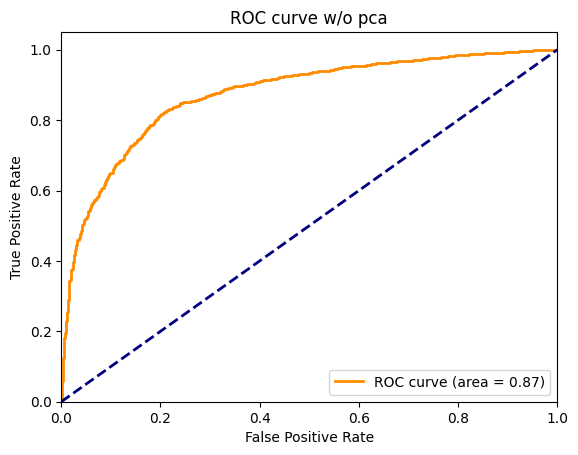

In [23]:
# Compute decision function scores
y_pred_best = grid_search.decision_function(X_test_selected)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_best)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve w/o pca')
plt.legend(loc="lower right")



# Save plot as PDF
plt.savefig('roc_curve_without_pca.pdf', format='pdf')
plt.show()


In [24]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=6)

# Remove constant features
constant_filter = VarianceThreshold(threshold=0)
X_train_nonconstant = constant_filter.fit_transform(X_train, y_train)
X_test_nonconstant = constant_filter.transform(X_test)

# Feature selection on non-constant features
selector = SelectKBest(f_classif, k=75)
X_train_selected = selector.fit_transform(X_train_nonconstant, y_train)
X_test_selected = selector.transform(X_test_nonconstant)

# Perform PCA with explained variance threshold of 95%
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)


So again highest C and gamma were preferred, so  i increased grid search. Observation: calculation times significantly decreased.

further increase, as it took again highest parameters as best

After testing hyperparameters with grid search both after feature selected data and feature selection + pca, C seems to be as high as possible and for gamma the same. Grid search with pca showed low calculation times, so bayesian optimization was performed on for C in range from 1 to 100 and gamma from 0.1 to 1.

In [25]:
# Define the bounds of the search space
pbounds = {'expC': (1,2), 'expgamma': (0, 1)}
# Constants outside the objective function
kernel = "rbf"

# Define the objective function to optimize
def objective_function(expC, expgamma):
    svm_model = SVC(C=10**expC, gamma=10**expgamma, kernel=kernel)
    cv_scores = cross_val_score(svm_model, X_train_pca, y_train, cv=5, verbose = 2)
    mean_cv_accuracy = np.mean(cv_scores)
    return mean_cv_accuracy



# Initialize Bayesian optimization search
bayes_search = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=42  # Setting the random state for reproducibility
)

# Perform Bayesian optimization
bayes_search.maximize(
    init_points=2,  # Number of random points to sample before optimization
    n_iter=10,      # Number of optimization iterations
)

# Get the best hyperparameters
best_hyperparams = bayes_search.max['params']
print("Best Hyperparameters:", best_hyperparams)




|   iter    |  target   |   expC    | expgamma  |
-------------------------------------------------
[CV] END .................................................... total time=   7.6s
[CV] END .................................................... total time=   7.1s
[CV] END .................................................... total time=   7.4s
[CV] END .................................................... total time=   8.0s
[CV] END .................................................... total time=   8.1s
| 1         | 0.7624    | 1.375     | 0.9507    |
[CV] END .................................................... total time=   8.1s
[CV] END .................................................... total time=   8.4s
[CV] END .................................................... total time=   8.0s
[CV] END .................................................... total time=   8.1s
[CV] END .................................................... total time=   8.0s
| 2         | 0.7649    | 1.732     | 0.

Best hyperparameters were for C = 55 and gamma = 1.24. Then model was trained and tested

[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   9.7s
[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time=   7.7s
[CV] END .................................................... total time=   7.5s
Accuracy of Final PCA Model after Cross-Validation: 0.7673828125
Classification Report for Final PCA Model:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1201
           1       0.76      0.78      0.77      1360

    accuracy                           0.76      2561
   macro avg       0.76      0.75      0.76      2561
weighted avg       0.76      0.76      0.76      2561

Confusion Matrix for Final PCA Model:
[[ 873  328]
 [ 295 1065]]
Accuracy on Test Set for Final PCA Model: 0.7567356501366653


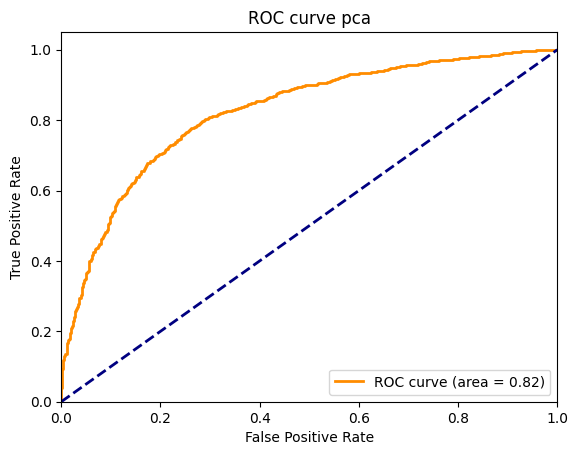

In [29]:
expC = 1.3951276597374727
expgamma = 0.4873730306434406

final_pca_svm_model = SVC(C=10 ** expC, gamma=10 ** expgamma, kernel="rbf")
final_pca_svm_model.fit(X_train_pca, y_train)

# Evaluate the final model with cross-validation
cv_scores_final_pca_model = cross_val_score(final_pca_svm_model, X_train_pca, y_train, cv=5, verbose = 2)
accuracy_final_pca_model = np.mean(cv_scores_final_pca_model)
print("Accuracy of Final PCA Model after Cross-Validation:", accuracy_final_pca_model)

# Predict labels using the final PCA model
y_pred_final_pca = final_pca_svm_model.predict(X_test_pca)

# Generate classification report
print("Classification Report for Final PCA Model:")
print(classification_report(y_test, y_pred_final_pca))

# Generate confusion matrix
print("Confusion Matrix for Final PCA Model:")
print(confusion_matrix(y_test, y_pred_final_pca))

# Calculate and print accuracy on the test set
test_accuracy_final_pca = accuracy_score(y_test, y_pred_final_pca)
print("Accuracy on Test Set for Final PCA Model:", test_accuracy_final_pca)




# Compute decision function scores
y_scores_final_pca = final_pca_svm_model.decision_function(X_test_pca)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_scores_final_pca)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve pca')
plt.legend(loc="lower right")

# Save plot as PDF
plt.savefig('roc_curve_pca.pdf', format='pdf')
plt.show()

rocw_data = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr})

# Save the DataFrame to a CSV file
rocw_data.to_csv('roc_with.csv', index=False)

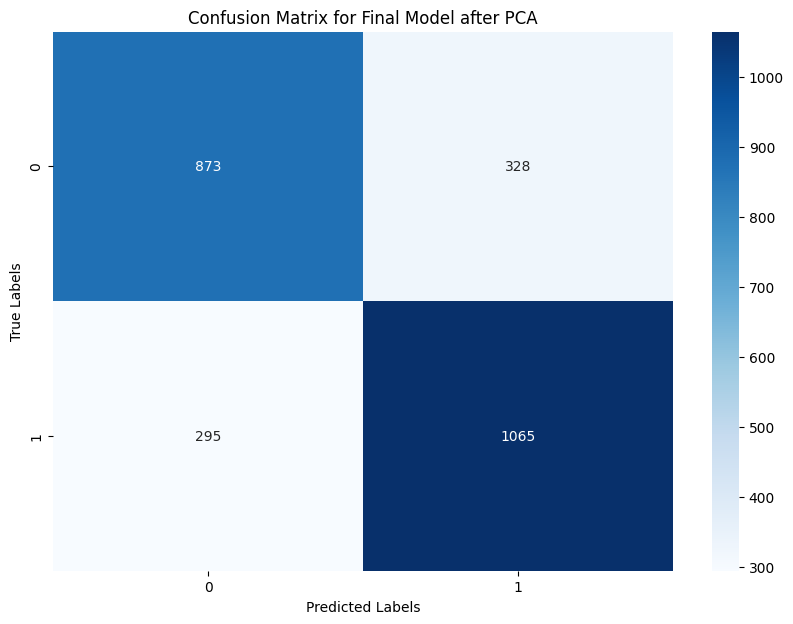

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_final_pca)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Final Model after PCA')
plt.show()

doesnt look bad, accuracy on test set 0.78, and ROC curve decent too. I wanted to try the parameters determined by bayesian opt for pca also for non pca data, but calculation times went through the roof again, so C=40 and gamma= 0.4 for non pca data. 

Conclusion: both models perform reasonably well, pca model exchanges 2% lower accuracy against much shorter calculation times. Both models have accuracy on test set arround 80%, which could maybe further improved by combining with other models or other boosting methods. Considering non pca model had not intended hyperparameters, accuracy could be much higher with much more time or better computer.

In [24]:
# Find misclassified examples
misclassified_indices = np.where(y_test != y_pred_final)[0]
# Access only the rows with the specified indices
error_df = df.loc[misclassified_indices]



In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume y_test, y_pred_final, X_test_selected, and df are already defined
# y_test and y_pred_final should be numpy arrays or pandas Series
# X_test_selected should be a numpy array or pandas DataFrame
# df should be a DataFrame containing your sequences with a matching index

# Find misclassified examples
misclassified_indices = np.where(y_test != y_pred)[0]

# Access only the rows with the specified indices
error_df = df.loc[misclassified_indices]







In [34]:
error_df = error_df.iloc[:, [0]]
error_df

,AB
1,0
6,0
7,0
8,0
12,0
...,...
2552,0
2554,0
2556,0
2558,0


In [115]:
import pandas as pd
from propy import PyPro
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm



# List of feature extraction methods
feature_methods = [
    'GetAAComp'
    
]

# Function to extract features
def extract_features(sequence):
    descriptor = PyPro.GetProDes(sequence)
    
    features = {}
    
    # Extract features using each method
    for method in feature_methods:
        try:
            feature = getattr(descriptor, method)()
            features.update(feature)
        except AttributeError:
            print(f"AttributeError: Method '{method}' not available for sequence '{sequence}'")
    
    return features

# Function to apply feature extraction with multithreading and tqdm progress bar
def extract_features_multithreaded(peptides, max_workers=4):
    features_list = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_sequence = {executor.submit(extract_features, seq): seq for seq in peptides}
        
        # Initialize tqdm progress bar
        with tqdm(total=len(future_to_sequence), desc="Extracting Features") as pbar:
            for future in as_completed(future_to_sequence):
                seq = future_to_sequence[future]
                try:
                    features = future.result()
                    features_list.append(features)
                except Exception as e:
                    print(f"Exception for sequence {seq}: {e}")
                finally:
                    pbar.update(1)  # Update progress bar

    return features_list

# Extract features using multithreading
features_list = extract_features_multithreaded(error_df['seq'])

# Create a DataFrame from the list of feature dictionaries
features_df = pd.DataFrame(features_list)

# Combine the original DataFrame with the features DataFrame
aa_df = pd.concat([error_df, features_df], axis=1)



Extracting Features: 100%|███████████████████████████████████████████████████████| 494/494 [00:00<00:00, 196210.81it/s]


In [114]:
import pandas as pd
from propy import PyPro
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm



# List of feature extraction methods
feature_methods = [
    
    'GetDPComp',
    
    
]

# Function to extract features
def extract_features(sequence):
    descriptor = PyPro.GetProDes(sequence)
    
    features = {}
    
    # Extract features using each method
    for method in feature_methods:
        try:
            feature = getattr(descriptor, method)()
            features.update(feature)
        except AttributeError:
            print(f"AttributeError: Method '{method}' not available for sequence '{sequence}'")
    
    return features

# Function to apply feature extraction with multithreading and tqdm progress bar
def extract_features_multithreaded(peptides, max_workers=4):
    features_list = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_sequence = {executor.submit(extract_features, seq): seq for seq in peptides}
        
        # Initialize tqdm progress bar
        with tqdm(total=len(future_to_sequence), desc="Extracting Features") as pbar:
            for future in as_completed(future_to_sequence):
                seq = future_to_sequence[future]
                try:
                    features = future.result()
                    features_list.append(features)
                except Exception as e:
                    print(f"Exception for sequence {seq}: {e}")
                finally:
                    pbar.update(1)  # Update progress bar

    return features_list

# Extract features using multithreading
features_list = extract_features_multithreaded(error_df['seq'])

# Create a DataFrame from the list of feature dictionaries
features_df = pd.DataFrame(features_list)

# Combine the original DataFrame with the features DataFrame
dp_df = pd.concat([error_df, features_df], axis=1)







Extracting Features: 100%|█████████████████████████████████████████████████████████| 494/494 [00:00<00:00, 1976.69it/s]


In [113]:
import pandas as pd
from propy import PyPro
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm



# List of feature extraction methods
feature_methods = [
    
    'GetTPComp'
    
]

# Function to extract features
def extract_features(sequence):
    descriptor = PyPro.GetProDes(sequence)
    
    features = {}
    
    # Extract features using each method
    for method in feature_methods:
        try:
            feature = getattr(descriptor, method)()
            features.update(feature)
        except AttributeError:
            print(f"AttributeError: Method '{method}' not available for sequence '{sequence}'")
    
    return features

# Function to apply feature extraction with multithreading and tqdm progress bar
def extract_features_multithreaded(peptides, max_workers=4):
    features_list = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_sequence = {executor.submit(extract_features, seq): seq for seq in peptides}
        
        # Initialize tqdm progress bar
        with tqdm(total=len(future_to_sequence), desc="Extracting Features") as pbar:
            for future in as_completed(future_to_sequence):
                seq = future_to_sequence[future]
                try:
                    features = future.result()
                    features_list.append(features)
                except Exception as e:
                    print(f"Exception for sequence {seq}: {e}")
                finally:
                    pbar.update(1)  # Update progress bar

    return features_list

# Extract features using multithreading
features_list = extract_features_multithreaded(error_df['seq'])

# Create a DataFrame from the list of feature dictionaries
features_df = pd.DataFrame(features_list)

# Combine the original DataFrame with the features DataFrame
tp_df = pd.concat([error_df, features_df], axis=1)



Extracting Features: 100%|███████████████████████████████████████████████████████████| 494/494 [02:29<00:00,  3.30it/s]


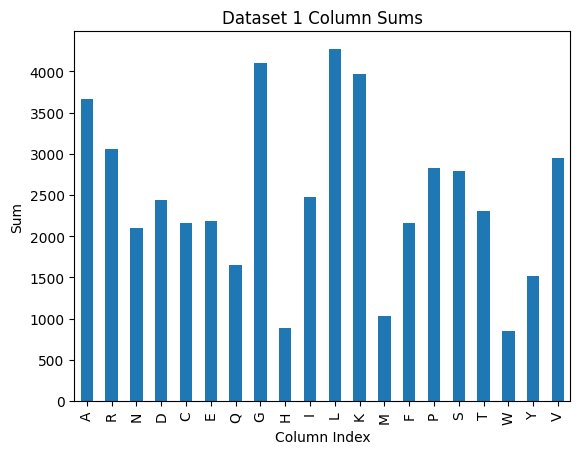

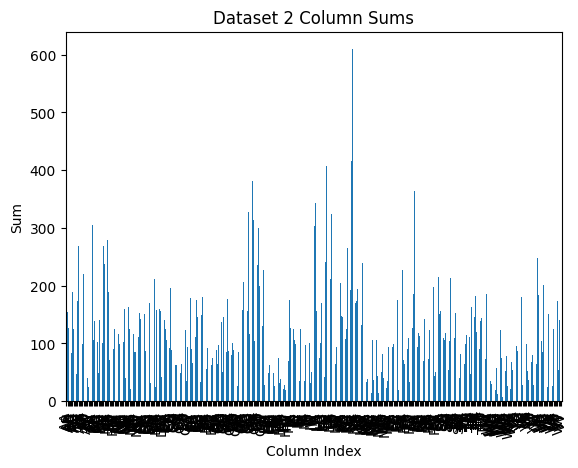

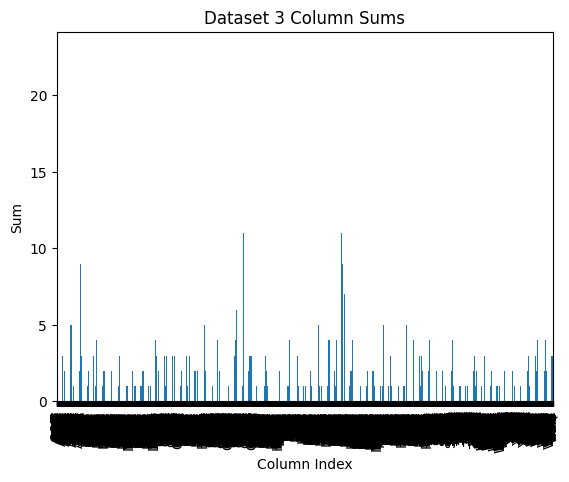

In [120]:
import matplotlib.pyplot as plt

# Assuming aa_df, dp_df, and tp_df are your DataFrames
datasets = [aa_df, dp_df, tp_df]

# Iterate over each dataset
for idx, df in enumerate(datasets, start=1):
    column_sums = df.iloc[:, 1:].sum()  # Calculate the sum of values in each column excluding the first column
    ax = column_sums.plot(kind='bar', title=f'Dataset {idx} Column Sums')  # Plot the column sums
    ax.set_xlabel('Column Index')
    ax.set_ylabel('Sum')
    ax.set_xticklabels(column_sums.index, rotation=90)  # Rotate x-axis labels vertically
    plt.show()


In [122]:
# Assuming df1, df2, and df3 are your DataFrames
datasets = [aa_df, dp_df, tp_df]

# Iterate over each dataset
for idx, df in enumerate(datasets, start=1):
    column_sums = df.iloc[:, 1:].sum()  # Calculate the sum of values in each column excluding the first column
    highest_sums = column_sums.nlargest(3)  # Get the top 3 columns with the highest sums
    print(f"Top columns in dataset {idx}:")
    print(highest_sums)


Top columns in dataset 1:
L    4272.823
G    4098.392
K    3974.187
dtype: float64
Top columns in dataset 2:
KK    609.30
AA    454.92
KL    415.46
dtype: float64
Top columns in dataset 3:
KKL    23.0
AAA    18.0
KGA    16.0
dtype: float64
